# Brain Tumor Detector

## Get and Load Dataset

In [147]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:
!pip install --upgrade --no-cache-dir gdown

In [149]:
!gdown --id 1RWvYrWtClFt9adNSgUlcekwv4X7VKwIp
#link didn't work

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1RWvYrWtClFt9adNSgUlcekwv4X7VKwIp
To: /content/brain_tumor.zip
100% 156M/156M [00:00<00:00, 182MB/s]


In [150]:
!wget -c 'https://drive.google.com/file/d/1RWvYrWtClFt9adNSgUlcekwv4X7VKwIp/view?usp=sharing' -O /content/brain_tumor.zip

--2022-03-25 12:49:16--  https://drive.google.com/file/d/1RWvYrWtClFt9adNSgUlcekwv4X7VKwIp/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 142.250.153.101, 142.250.153.113, 142.250.153.139, ...
Connecting to drive.google.com (drive.google.com)|142.250.153.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/content/brain_tumor.zip’

/content/brain_tumo     [  <=>               ]  63.89K   304KB/s    in 0.2s    

2022-03-25 12:49:17 (304 KB/s) - ‘/content/brain_tumor.zip’ saved [155791278]



In [151]:
! cp /content/brain_tumor.zip ./brain_tumor.test.zip

In [152]:
! unzip /content/brain_tumor.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [153]:
ls -l

total 304300
-rw-r--r-- 1 root root 155791278 Mar 25 12:49 brain_tumor.test.zip
-rw-r--r-- 1 root root 155791278 Mar 25 12:49 brain_tumor.zip
drwx------ 5 root root      4096 Mar 25 09:15 drive/
drwxr-xr-x 3 root root      4096 Mar 25 09:59 logs/
drwxr-xr-x 1 root root      4096 Mar 23 14:22 sample_data/
drwxr-xr-x 6 root root      4096 Mar 25 09:21 Testing/
drwxr-xr-x 6 root root      4096 Mar 25 09:21 Training/


In [154]:
!sudo apt-get install tree #just to see folder structures, run only on linux systems like colab

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [155]:
!tree --dirsfirst --filelimit 4 ./Training/

./Training/
├── glioma [1321 entries exceeds filelimit, not opening dir]
├── meningioma [1339 entries exceeds filelimit, not opening dir]
├── notumor [1595 entries exceeds filelimit, not opening dir]
└── pituitary [1457 entries exceeds filelimit, not opening dir]

4 directories, 0 files


In [156]:
!tree --dirsfirst --filelimit 4 ./Testing/ #just to see folder structures, run only on linux systems like colab

./Testing/
├── glioma [300 entries exceeds filelimit, not opening dir]
├── meningioma [306 entries exceeds filelimit, not opening dir]
├── notumor [405 entries exceeds filelimit, not opening dir]
└── pituitary [300 entries exceeds filelimit, not opening dir]

4 directories, 0 files


## Load Dependencies

In [157]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.8.0


## Utility functions to create dataset generators

In [188]:
IMG_DIMS = (224, 224)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=224,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), 
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions


In [189]:
def plot_metrics(history):

  keys = history.history.keys()
  metrics = ['loss', 'sparse_categorical_accuracy']
  plt.figure(figsize=(12, 10))
  for n, metric in enumerate(metrics):
    name = metric.capitalize()
    metric_name = [item for item in keys if metric in item and 'val_'+metric not in item][0]
    val_metric_name = [item for item in keys if 'val_'+metric in item][0]
    
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric_name], color='b', label='Train')
    plt.plot(history.epoch, history.history[val_metric_name], color='r', 
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10, 
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [190]:
#train_ds, val_ds = prepare_train_and_val_datasets()

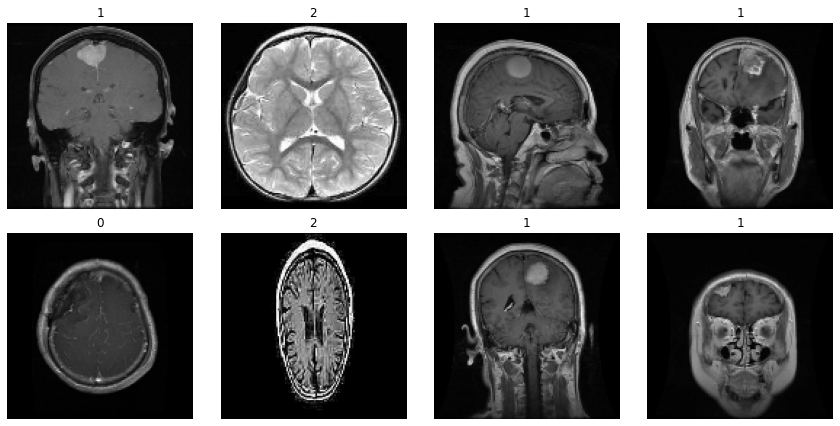

In [191]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

## If you want to apply data augmentation operations on the train dataset

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
```


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__

In [192]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import EfficientNetB0


train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [193]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout

model1 = Sequential()
model1.add(InputLayer(input_shape=(224, 224, 3)))
# 1st conv block
model1.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model1.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# 2nd conv block
model1.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model1.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model1.add(BatchNormalization())
# 3rd conv block
model1.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model1.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model1.add(BatchNormalization())
# ANN block
model1.add(Flatten())
model1.add(Dense(units=100, activation='relu'))
model1.add(Dense(units=100, activation='relu'))
model1.add(Dropout(0.25))
# output layer
model1.add(Dense(4, activation='softmax'))
model1.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 224, 224, 25)      1900      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 112, 112, 25)     0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 56, 56, 50)        31300     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 28, 28, 50)       0         
 g2D)                                                            
                                                                 
 batch_normalization_27 (Bat  (None, 28, 28, 50)       200       
 chNormalization)                                                
                                                     

In [194]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model1.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

history1 = model1.fit(train_ds, epochs=30, callbacks=early_stopping, validation_data=val_ds)

Epoch 1/30
143/143 [==============================] - 10s 61ms/step - loss: 0.6315 - sparse_categorical_accuracy: 0.7632 - val_loss: 1.2091 - val_sparse_categorical_accuracy: 0.5919
Epoch 2/30
143/143 [==============================] - 9s 59ms/step - loss: 0.3324 - sparse_categorical_accuracy: 0.8720 - val_loss: 1.2049 - val_sparse_categorical_accuracy: 0.5919
Epoch 3/30
143/143 [==============================] - 9s 58ms/step - loss: 0.2319 - sparse_categorical_accuracy: 0.9125 - val_loss: 0.3164 - val_sparse_categorical_accuracy: 0.8844
Epoch 4/30
143/143 [==============================] - 9s 59ms/step - loss: 0.1593 - sparse_categorical_accuracy: 0.9405 - val_loss: 0.2809 - val_sparse_categorical_accuracy: 0.9159
Epoch 5/30
143/143 [==============================] - 9s 59ms/step - loss: 0.1411 - sparse_categorical_accuracy: 0.9495 - val_loss: 0.3840 - val_sparse_categorical_accuracy: 0.8687
Epoch 6/30
143/143 [==============================] - 9s 58ms/step - loss: 0.1099 - sparse_cat

In [195]:
from sklearn.metrics import classification_report

y_true1, y_pred1 = eval_model_on_test(model1)
y_pred1 = np.argmax(y_pred1,axis=1)
print(classification_report(y_true=y_true1, y_pred=y_pred1, target_names=classes))

Found 1311 files belonging to 4 classes.


Predicting on Test Data: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]

              precision    recall  f1-score   support

      glioma       0.97      0.72      0.83       300
  meningioma       0.74      0.85      0.79       306
     notumor       0.89      0.98      0.93       405
   pituitary       0.98      0.94      0.96       300

    accuracy                           0.88      1311
   macro avg       0.89      0.87      0.88      1311
weighted avg       0.89      0.88      0.88      1311



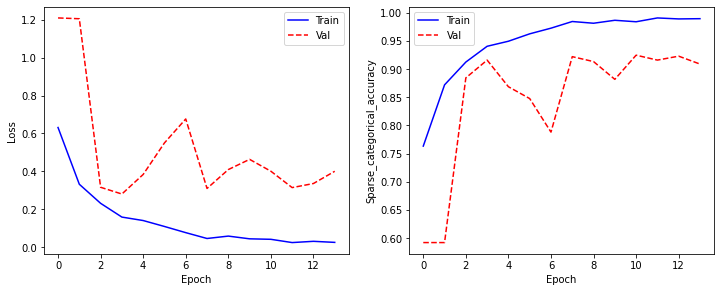

In [196]:
plot_metrics(history1)

In [197]:
effnetb0 = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

In [198]:
model = effnetb0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnetb0.input, outputs = model)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 224, 224, 3)  0           ['input_14[0][0]']               
                                                                                                  
 normalization_5 (Normalization  (None, 224, 224, 3)  7          ['rescaling_5[0][0]']            
 )                                                                                                
                                                                                            

In [199]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = 'Adam', metrics= tf.keras.metrics.SparseCategoricalAccuracy())

history = model.fit(train_ds, validation_data=val_ds, epochs =10, batch_size=BATCH_SIZE)

Epoch 1/10
143/143 [==============================] - 46s 258ms/step - loss: 0.2527 - sparse_categorical_accuracy: 0.9053 - val_loss: 0.4057 - val_sparse_categorical_accuracy: 0.8949
Epoch 2/10
143/143 [==============================] - 35s 243ms/step - loss: 0.1083 - sparse_categorical_accuracy: 0.9646 - val_loss: 0.4247 - val_sparse_categorical_accuracy: 0.9046
Epoch 3/10
143/143 [==============================] - 35s 244ms/step - loss: 0.0619 - sparse_categorical_accuracy: 0.9803 - val_loss: 0.0646 - val_sparse_categorical_accuracy: 0.9764
Epoch 4/10
143/143 [==============================] - 35s 243ms/step - loss: 0.0524 - sparse_categorical_accuracy: 0.9858 - val_loss: 0.3701 - val_sparse_categorical_accuracy: 0.8765
Epoch 5/10
143/143 [==============================] - 35s 243ms/step - loss: 0.0375 - sparse_categorical_accuracy: 0.9873 - val_loss: 0.1345 - val_sparse_categorical_accuracy: 0.9510
Epoch 6/10
143/143 [==============================] - 35s 243ms/step - loss: 0.0384 -

In [200]:
y_true, y_pred = eval_model_on_test(model)

from sklearn.metrics import classification_report

y_pred = np.argmax(y_pred,axis=1)
#y_true = np.argmax(y_true,axis=1)
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=classes))


Found 1311 files belonging to 4 classes.


Predicting on Test Data: 100%|██████████| 6/6 [00:08<00:00,  1.40s/it]

              precision    recall  f1-score   support

      glioma       0.99      0.98      0.98       300
  meningioma       0.95      0.99      0.97       306
     notumor       1.00      0.99      1.00       405
   pituitary       1.00      0.98      0.99       300

    accuracy                           0.99      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.99      0.99      0.99      1311



     0    1    2    3
0  293    7    0    0
1    1  304    0    1
2    0    3  402    0
3    2    5    0  293


[Text(0, 0.5, 'glioma'),
 Text(0, 1.5, 'meningioma'),
 Text(0, 2.5, 'notumor'),
 Text(0, 3.5, 'pituitary')]

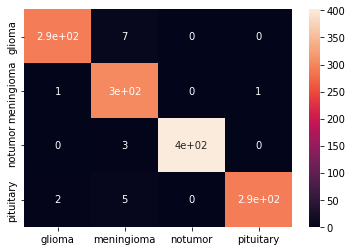

In [219]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print(pd.DataFrame(cm))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

In [217]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

perf_measure(y_true, y_pred)

(304, 15, 293, 3)

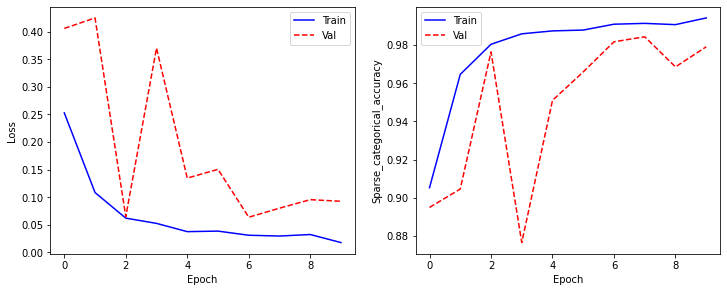

In [201]:
plot_metrics(history)

In [202]:
#VGG16
from keras.applications.vgg16 import VGG16, preprocess_input

vgg = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    classes=4,
    classifier_activation="softmax",
)

In [203]:
modelvgg = Sequential()
modelvgg.add(vgg)
modelvgg.add(layers.Dropout(0.3))
modelvgg.add(layers.Flatten())
modelvgg.add(layers.Dropout(0.5))
modelvgg.add(layers.Dense(4, activation='softmax'))

modelvgg.layers[0].trainable = False

modelvgg.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dropout_38 (Dropout)        (None, 7, 7, 512)         0         
                                                                 
 flatten_18 (Flatten)        (None, 25088)             0         
                                                                 
 dropout_39 (Dropout)        (None, 25088)             0         
                                                                 
 dense_58 (Dense)            (None, 4)                 100356    
                                                                 
Total params: 20,124,740
Trainable params: 100,356
Non-trainable params: 20,024,384
_________________________________________________________________


In [204]:
modelvgg.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = 'Adam', metrics= tf.keras.metrics.SparseCategoricalAccuracy())

historyvgg = modelvgg.fit(train_ds, validation_data=val_ds, epochs =30, batch_size=BATCH_SIZE)

Epoch 1/30
143/143 [==============================] - 20s 129ms/step - loss: 4.4557 - sparse_categorical_accuracy: 0.7937 - val_loss: 2.0064 - val_sparse_categorical_accuracy: 0.9054
Epoch 2/30
143/143 [==============================] - 17s 120ms/step - loss: 2.4287 - sparse_categorical_accuracy: 0.8910 - val_loss: 1.3387 - val_sparse_categorical_accuracy: 0.9378
Epoch 3/30
143/143 [==============================] - 18s 121ms/step - loss: 1.8291 - sparse_categorical_accuracy: 0.9184 - val_loss: 1.7906 - val_sparse_categorical_accuracy: 0.9212
Epoch 4/30
143/143 [==============================] - 17s 120ms/step - loss: 1.8848 - sparse_categorical_accuracy: 0.9256 - val_loss: 1.9048 - val_sparse_categorical_accuracy: 0.9247
Epoch 5/30
143/143 [==============================] - 17s 120ms/step - loss: 1.5648 - sparse_categorical_accuracy: 0.9394 - val_loss: 1.7945 - val_sparse_categorical_accuracy: 0.9326
Epoch 6/30
143/143 [==============================] - 17s 120ms/step - loss: 1.4586 -

In [205]:
y_truev, y_predv = eval_model_on_test(modelvgg)

y_predv = np.argmax(y_predv,axis=1)
print(classification_report(y_true=y_truev, y_pred=y_predv, target_names=classes))

Found 1311 files belonging to 4 classes.


Predicting on Test Data: 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]

              precision    recall  f1-score   support

      glioma       0.94      0.91      0.93       300
  meningioma       0.88      0.90      0.89       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.97      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



In [206]:
data_augmentation = tf.keras.Sequential( #we do this as a layer in our network
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1), 
  ]
)

modell = Sequential([
  data_augmentation,
  vgg,
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(4, activation='softmax')
  ])

In [207]:
modell.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = 'Adam', metrics= tf.keras.metrics.SparseCategoricalAccuracy())

historyl = modell.fit(train_ds, validation_data=val_ds, epochs =30, batch_size=BATCH_SIZE)

Epoch 1/30
143/143 [==============================] - 20s 125ms/step - loss: 6.7749 - sparse_categorical_accuracy: 0.6976 - val_loss: 3.3519 - val_sparse_categorical_accuracy: 0.8529
Epoch 2/30
143/143 [==============================] - 18s 124ms/step - loss: 6.2515 - sparse_categorical_accuracy: 0.7672 - val_loss: 4.8945 - val_sparse_categorical_accuracy: 0.8214
Epoch 3/30
143/143 [==============================] - 18s 124ms/step - loss: 6.3866 - sparse_categorical_accuracy: 0.7847 - val_loss: 4.6161 - val_sparse_categorical_accuracy: 0.8354
Epoch 4/30
143/143 [==============================] - 18s 124ms/step - loss: 6.9840 - sparse_categorical_accuracy: 0.7921 - val_loss: 3.6272 - val_sparse_categorical_accuracy: 0.8905
Epoch 5/30
143/143 [==============================] - 18s 125ms/step - loss: 6.4422 - sparse_categorical_accuracy: 0.8059 - val_loss: 5.1425 - val_sparse_categorical_accuracy: 0.8529
Epoch 6/30
143/143 [==============================] - 18s 124ms/step - loss: 7.1020 -

In [208]:
y_truel, y_predl = eval_model_on_test(modell)

y_predl = np.argmax(y_predl,axis=1)
print(classification_report(y_true=y_truel, y_pred=y_predl, target_names=classes))

Found 1311 files belonging to 4 classes.


Predicting on Test Data: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]

              precision    recall  f1-score   support

      glioma       0.91      0.78      0.84       300
  meningioma       0.77      0.62      0.68       306
     notumor       0.92      0.97      0.94       405
   pituitary       0.78      0.99      0.87       300

    accuracy                           0.85      1311
   macro avg       0.84      0.84      0.84      1311
weighted avg       0.85      0.85      0.84      1311

